# PROJECT STARTS HERE

# Importing Libraries and Modules

In [1]:
import sklearn
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
# import time
# import mediapipe as mp
# import csv
import pandas as pd
import tensorflow as tf
from PIL import Image, ImageEnhance
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Frame Extraction

In [ ]:
# Folder path of dataset
folder_path = r'D:\FYP_HWU\Videos'
DATA_PATH = r'D:\FYP_HWU'

In [ ]:
# List of actions to train model with (10 classes or actions)
actions = [
'accident',
'call',
'help',
'man',
'murder',
'woman',
'danger',
'police',
'follow',
'child'
]


### Counting number of videos under each action in the dataset

In [ ]:
# Initializing the path of the dataset
folder_path = r'D:\WLASL Datasets\Kaggle_WLASL_withVideosInClassFolders\dataset\SL'

#### Getting a count of videos per action mentioned in the actions list

In [ ]:
# Initializing variables
video_count = {}
folder_path = r'D:\FYP_HWU\NEW_Frames'

# Creating a dictionary for all the actions/classes along with the count of videos for each action in the dataset
for root, dirs, files in os.walk(folder_path):
    for i in dirs: #loop through each of the keywords or actions in the dataset
        if (i in actions): #if the keyword is present in the shortlisted list of actions
            for root, dirs, files in os.walk(os.path.join(folder_path, i)):
                video_count[i] = len(dirs) #get the number of videos per class and append to the dictionary
                break
    break

print(video_count)

{'accident': 13, 'call': 12, 'child': 9, 'danger': 11, 'follow': 9, 'help': 14, 'man': 12, 'murder': 13, 'police': 10, 'sick': 10, 'woman': 11}


#### Getting the classes with highest number of videos

In [ ]:
# Initializing variables
video_count = {}
first_11_items = {}

# Creating a dictionary for all the actions/classes along with the count of videos for each action in the dataset
for root, dirs, files in os.walk(folder_path):
    for i in dirs: #loop through each of the keywords or actions in the dataset
        for root, dirs, files in os.walk(os.path.join(folder_path, i)):
            video_count[i] = len(files)
            break

    break


In [ ]:
video_count1 = sorted(video_count.items(), key=lambda x:x[1], reverse = True)  #sorting the dictionary based on the number of videos and reversing it to arrange in s=descending order

In [ ]:
# getting the top 11 classes
for idx, k in enumerate(video_count1):
    if idx == 11: break
    first_11_items[k[0]] = k[1]

print(first_11_items)

{'cousin': 17, 'before': 16, 'cool': 16, 'thin': 16, 'drink': 15, 'go': 15, 'computer': 14, 'help': 14, 'inform': 14, 'take': 14, 'who': 14}


### Getting the video paths of the videos

In [ ]:
video_paths = {} #declaring an empty dictionary to store the file paths

# Creating a dictionary for all the actions/classes along with the count of videos for each action in the dataset
for root, dirs, files in os.walk(folder_path):

    for action in actions:  #iterating through each action in the actions list
        for root, dirs, files in os.walk(os.path.join(folder_path, action)):  # accessing files and folders under each class
            for i in range (len(files)):    # iterating through videos in the class folder
                files[i] = os.path.join(folder_path, action, files[i]) #storing video paths in the dictionary
            video_paths[action] = files
            break
    break

In [ ]:
# storing the file paths (video paths) in a csv file
df = pd.DataFrame.from_dict(video_paths, orient='index')
df = df.transpose()
df.to_csv('video_paths.csv', index=False)

In [ ]:
# Reading the csv file to get the video paths and storing them in a dictionary
def read_csv_to_dict(csv_file):
    result_dict = {}

    with open(csv_file, 'r') as file:
        csv_reader = csv.reader(file)

        # Read the header row to get the keys
        keys = next(csv_reader, None)
        if keys:
            for key in keys:
                result_dict[key] = []

            # Read the rest of the rows and store values in the dictionary
            for row in csv_reader:
                for i in range(len(keys)):
                    result_dict[keys[i]].append(row[i])

    return result_dict

In [ ]:
video_paths = read_csv_to_dict("video_paths.csv")

### Creating folders to store frames

In [ ]:
#Creating folder 'NEW_Frames' that will contain all the video frames
DATA_PATH = r'D:\FYP_HWU'
os.makedirs(os.path.join(DATA_PATH,'NEW_Frames'))

In [ ]:
#Creating one folder for each action
for action in video_paths.keys():
    # 1 folder for each video of the action
    for sequence in range(len(video_paths[action])):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

## Extracting frames from videos and adding them to folders

2 Approaches have be defined for frame extraction. 
The second approach has be used for this implementation.

### APPROACH 1
Here, a fixed number of frames are extracted from each video (60 in this case). If the extracted frames from a video are less than 60, then the last frame is repeated to reach the 60 count. If the video is too long, then then the first 60 frames of the video will be extracted.

In [ ]:
#looping through each action
for action in video_paths.keys():

    #Looping through each video of the action
    for sequence in range(len(video_paths[action])):

        # Open the video file
        cap = cv2.VideoCapture(video_paths[action][sequence])

        # Initializing variables
        frame_count = 0       # current frame count
        max_fc = 60          # maximum frame count


        #while the video is accessible and the current frame count doesn't exceed the max frame count limit
        while (cap.isOpened() and frame_count < max_fc):
            #reading the video frame
            success, frame = cap.read()

            #if there are frames
            if success:
                image = frame.copy()
                cv2.imshow("{} - {}".format(action, sequence), image)

                #saving the extracted frames (in jpg format)
                cv2.imwrite(os.path.join(DATA_PATH , action, str(sequence), 'frame'+ str(frame_count) + '.jpg'), image)
                frame_count+=1
            else:
                break

        # repeat last frame until we reach max frame count
        while frame_count < max_fc:
            cv2.imwrite(os.path.join(DATA_PATH , action, str(sequence), 'frame'+ str(frame_count) + '.jpg'), image)
            frame_count+=1

        cap.release()
        cv2.destroyAllWindows()

### APPROACH 2
Here too, a fixed number of frames are extracted from each video (20 in this case). The frames will be extracted after dividing the complete video into equal parts and then choosing the frames from each part. This way we will be able to avoid the first few or last frames few of the video if no action is being depicted. Secondly, the basic movement of the action is captured.

In [29]:
# Deciding how many frames to extract?
count = []
for action in video_paths.keys():
        #Looping through each video of the action
        for sequence in range(len(video_paths[action])):
            cap = cv2.VideoCapture(video_paths[action][sequence])
            total_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
            count.append(total_frames)
            cap.release()

In [ ]:
print(min(count))

In [ ]:
print(max(count))

155.0


In [ ]:
# Defining a path to store the extracted frames
DATA_PATH = r'D:\FYP_HWU\NEW_Frames'

In [ ]:
# This function determines the frames to be skipped to extract frames from videos of variable lengths.
def frameSkipping(video_paths, n):
    for action in video_paths.keys():

        #Looping through each video of the action
        for sequence in range(len(video_paths[action])):
            cap = cv2.VideoCapture(video_paths[action][sequence])

            total_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)  #getting the total frame count
            frames_step = total_frames//n    # getting the number of frames to skip

            for frame_num in range(n):
                #position the pointer to the frame after skipping frames
                cap.set(1,frame_num*frames_step)
                success,image = cap.read()
                #save the image
                cv2.imwrite(os.path.join(DATA_PATH, action, str(sequence), 'frame'+ str(frame_num) + '.jpg'), image)

            cap.release()


In [ ]:
frameSkipping(video_paths, 20)

# Data Preprocessing
By the end of this section, we will folders containing the images frames stored in jpg format for each video of each action.

## Resizing Images

Resizing the images to 224 x 224 pixel size to feed to ResNet50 and Xception pre-trained model.

In [ ]:
# Cropping the center of the image (cropping out the extra background margins of the video.)
def crop_center_square(frame): # takes image as a parameter
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y:start_y+min_dim,start_x:start_x+min_dim]

In [ ]:
# Function to resize the frames
def resizeFrames(new_image, resize): # takes numpy array as parameter
    new_image = crop_center_square(new_image)
    new_image = cv2.resize(new_image, resize)
    return new_image # returns a numpy array

In [ ]:
max_fc = 20
resize = (224,224)
AUG_PATH = r'D:\FYP_HWU\NEW_AUG_Frames'
DATA_PATH = r'D:\FYP_HWU\NEW_Frames'

videoCount = totalVideoCount(DATA_PATH) #getting a video count from original frame dataset

#looping through each action
for action in videoCount.keys():

    #Looping through the count for videos for that action
    for sequence in range(videoCount[action]):

        #creating a folder in AUG frames folder
        try:
            os.makedirs(os.path.join(AUG_PATH, action, str(sequence)))
        except:
            pass

        # iterating through each frame in the original frame dataset
        for frame_num in range (max_fc):
            IMAGE_PATH = os.path.join(DATA_PATH, str(action), str(sequence) , 'frame' + str(frame_num) + '.jpg')

            # Reading the image
            image = cv2.imread(IMAGE_PATH)

            new_image = resizeFrames(image, resize)

            #Saving the image in the folder created
            cv2.imwrite(os.path.join(AUG_PATH, str(action), str(sequence), 'frame' + str(frame_num) + '.jpg'), new_image)

            # Displaying Image
            cv2.destroyAllWindows()


## Data Augmentation
 Using:
 - Frame Mirroring (Flipping the image horizontally)
 - Changing contrast, brightness and saturation levels
 - Rotating

 Here, we take each video, apply the above video augmentation filters and store them in a seperate folder.


In [ ]:
def blackAndWhite(image): # takes image as a parameter
    # Image color
    enhancer = ImageEnhance.Color(image)
    new_image = enhancer.enhance(0)

    # return np.array(new_image)
    return new_image

In [ ]:
def saturation(image): # takes image as a parameter
    # Horizontally flipping the image
    image = flipImage(image)
    # Image color
    enhancer = ImageEnhance.Color(image)
    new_image = enhancer.enhance(1.5)

    # return np.array(new_image)
    return new_image

In [ ]:
def flipImage(image): # takes image as a parameter
    # Converting Image to numpy array
    new_image = np.array(image)

    # Horizontally flipping the image
    image = cv2.flip(new_image, 1)

    # Converting numpy aray to image format
    image = Image.fromarray(image.astype('uint8'))

    # Returning the image in image format
    return image

In [ ]:
def rotateImage(image):
    image  = image.rotate(-8)  #- or + -> left or right
    return image

In [ ]:
# Getting the final number of videos under each Action
def totalVideoCount(DATA_PATH):
    finalVideoCount = {}
    for root, dirs, files in os.walk(DATA_PATH):
        for folder in dirs:
            for root, dirs, files in os.walk(os.path.join(DATA_PATH, folder)):
                finalVideoCount[folder] = len(dirs)
                break
    return finalVideoCount

In [ ]:
DATA_PATH = r'D:\FYP_HWU\NEW_Frames'
VideoCount = totalVideoCount(DATA_PATH)
print(VideoCount)

{'accident': 13, 'call': 12, 'child': 9, 'danger': 11, 'follow': 9, 'help': 14, 'man': 12, 'murder': 13, 'police': 10, 'sick': 10, 'woman': 11}


In [ ]:
max_fc = 20  #maximum number of frames extracted per video
resize = (224,224) #dimensions to resize the image to
AUG_PATH = r'D:\FYP_HWU\NEW_AUG_Frames' # defining file path to store the video frames after data augmentation
DATA_PATH = r'D:\FYP_HWU\NEW_Frames'

finalVideoCount = totalVideoCount(AUG_PATH)
video_count = totalVideoCount(DATA_PATH)

#looping through each action
for action in video_count.keys():
    actionCount = finalVideoCount[action]

    #Looping through the count for videos for that action
    for sequence in range(video_count[action]):

        #creating a folder to store the augmented images
        folder_number = actionCount + sequence
        if(folder_number < 45):  # limiting number of videos under each class to be 45
            try:
                os.makedirs(os.path.join(AUG_PATH, action, str(folder_number)))
            except:
                pass #pass if the folder has already been created

            for frame_num in range (max_fc):
                IMAGE_PATH = os.path.join(AUG_PATH, str(action), str(sequence) , 'frame' + str(frame_num) + '.jpg')

                # Reading the image
                image = cv2.imread(IMAGE_PATH)

                #Converting numpy array to Image
                image = Image.fromarray(image.astype('uint8'))

                # Applying the filters
#                 new_image = blackAndWhite(image)
#                 new_image = flipImage(image)
#                 new_image = saturation(image)
                new_image = rotateImage(image)

                # Converting Image to numpy array
                new_image = np.array(new_image)

                #Saving the image in the folder created
                cv2.imwrite(os.path.join(AUG_PATH , str(action), str(folder_number), 'frame'+ str(frame_num) + '.jpg'), new_image)

                # Displaying Image
                cv2.destroyAllWindows()

        else:
            break


In [ ]:
finalVideoCount = totalVideoCount(AUG_PATH)
print(finalVideoCount)

{'accident': 45, 'call': 45, 'child': 45, 'danger': 45, 'follow': 45, 'help': 45, 'man': 45, 'murder': 45, 'police': 45, 'sick': 45, 'woman': 45}


## Keypoint Extraction using MediaPipe Holistics
Applying MediaPipe Keypoint Landmarks to the augmented frames.

In [ ]:
mp_holistic = mp.solutions.holistic #Holistic model (use for detections)
mp_drawing = mp.solutions.drawing_utils #Drawing Utilities
drawing_spec = mp_drawing.DrawingSpec(thickness = 1, circle_radius=1)

In [ ]:
#Capturing landmarks
def mediapipeHolistics(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #color conversion -> BGR to RGB
    image.flags.writeable = False
    results = model.process(image) # Making Prediction
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) #color conversion -> RGB to BGR
    return image, results

In [ ]:
#Visualize landmarks, connecting the landmarks on the image (drawing only pose and had landmarks)
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image = image,
                              landmark_list = results.pose_landmarks,
                              connections = mp_holistic.POSE_CONNECTIONS,
                              landmark_drawing_spec = drawing_spec,
                              connection_drawing_spec = drawing_spec)
    mp_drawing.draw_landmarks(image = image,
                              landmark_list = results.left_hand_landmarks,
                              connections = mp_holistic.HAND_CONNECTIONS,
                              landmark_drawing_spec = drawing_spec,
                              connection_drawing_spec = drawing_spec)
    mp_drawing.draw_landmarks(image = image,
                              landmark_list = results.right_hand_landmarks,
                              connections = mp_holistic.HAND_CONNECTIONS,
                              landmark_drawing_spec = drawing_spec,
                              connection_drawing_spec = drawing_spec)

In [ ]:
max_fc = 20
AUG_PATH = r'D:\FYP_HWU\NEW_AUG_Frames'
FRAMES_PATH = r'D:\FYP_HWU\NEW_MP_Frames'

finalVideoCount = totalVideoCount(AUG_PATH)

#looping through each action
for action in finalVideoCount.keys():

    #Looping through the count for videos for that action
    for sequence in range(finalVideoCount[action]):

        # Creating folders to store frames and extracted landmarks
        try:
            os.makedirs(os.path.join(FRAMES_PATH, action, str(sequence)))
        except:
            pass

        with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:
            for frame_num in range (max_fc):

                # Getting the extracted frame from the folder
                IMAGE_PATH = os.path.join(AUG_PATH, str(action), str(sequence) , 'frame' + str(frame_num) + '.jpg')

                # Reading the image
                image = cv2.imread(IMAGE_PATH)

                # Making detection
                image, result = mediapipeHolistics(image, holistic)

                #Darwing landmarks on frames
                draw_landmarks(image,result)

                #Saving the image in the folder created
                cv2.imwrite(os.path.join(FRAMES_PATH , str(action), str(sequence), 'frame'+ str(frame_num) + '.jpg'), image)

                # Displaying Image
                cv2.destroyAllWindows()


# Creating the Dataset

## Visualizing dataset frames

In [3]:
from PIL import Image, ImageEnhance
from IPython.display import Image
DATA_PATH = r'D:\FYP_HWU\NEW_MP_Frames'

ACTION: Man    Video: 0     Frame: 22


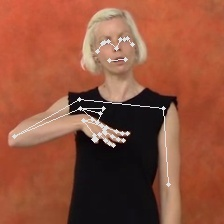

In [ ]:
# man (video 0, frame 22)
print("ACTION: Man    Video: 0     Frame: 22")
display(Image(filename="{}/man/0/frame15.jpg". format(DATA_PATH)))

## Creating Labels and Features

In [4]:
# import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
# Splitting data in 80:10:10 train:validation:test ratio
def trainTestSplit(X,y):
    x_train, x_temp, y_train, y_temp= train_test_split(X, y, test_size=0.2, random_state=42)
    x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size = 0.5, random_state=42)
    return x_train, y_train, x_val, y_val, x_test, y_test

In [13]:
# Initializing data path
DATA_PATH = r'C:\Users\revan\Documents\FYP_HWU\NEW_MP_Frames'

In [8]:
# Getting the final number of videos under each Action
def totalVideoCount(DATA_PATH):
    finalVideoCount = {}
    for root, dirs, files in os.walk(DATA_PATH):
        for folder in dirs:
            for root, dirs, files in os.walk(os.path.join(DATA_PATH, folder)):
                finalVideoCount[folder] = len(dirs)
                break
    return finalVideoCount

In [9]:
# Getting the final number of videos under each Action
total_video_count = totalVideoCount(DATA_PATH)
temp_list = ['police', 'follow', 'child', 'woman', 'man', 'help', 'call', 'danger', 'murder', 'accident']
subset_video_count = {}
for temp in temp_list:
    subset_video_count[temp] = total_video_count[temp]

print(subset_video_count)

{'police': 45, 'follow': 45, 'child': 45, 'woman': 45, 'man': 45, 'help': 45, 'call': 45, 'danger': 45, 'murder': 45, 'accident': 45}


In [10]:
# Setting numeric labels for non numeric action category values
label_map = {label:num for num, label in enumerate(subset_video_count.keys())} #subset of classes

In [11]:
print(label_map)

{'police': 0, 'follow': 1, 'child': 2, 'woman': 3, 'man': 4, 'help': 5, 'call': 6, 'danger': 7, 'murder': 8, 'accident': 9}


### Frame Enhancement

In [12]:
# Converting frames from BGR to RGB format and normalizing pixel values
def frameEnhance(frame):
    # Converting BGR -> RGB
    frame = frame[:, :, [2, 1, 0]]
    # Normalize the pixel values
    frame = frame / 255.0
    return frame

#### For ALL classes

In [8]:
# Adding videos to list (grouping the 20 frames in a list) 
max_fc = 20
videoFrames=[]
videolabels=[]

# Iterating through each action
for action in total_video_count.keys():

    # Iterting through each video in the action
    for sequence in range(total_video_count[action]):

        # Declaring a list to store the frames of each video
        frames = []

        # Iterating through each frame
        for frame_num in range(max_fc):

            # Loading the image frame
            frame = cv2.imread(os.path.join(DATA_PATH, action, str(sequence), "frame{}".format(frame_num) + ".jpg"))
            frame = frameEnhance(frame)

            # Appending to the list
            frames.append(frame)

        # Adding to the dataset
        videoFrames.append(frames)
        videolabels.append(label_map[action])

    print("Action {} done".format(action))
cv2.destroyAllWindows()

Action accident done
Action call done
Action child done
Action danger done
Action follow done
Action help done
Action man done
Action murder done
Action police done
Action sick done
Action woman done


In [ ]:
# Adding individual frames to list for feature extraction
# max_fc = 20
# videoFrames=[]
# videolabels=[]

# # Iterating through each action
# for action in total_video_count.keys():

#     # Iterting through each video in the action
#     for sequence in range(total_video_count[action]):

#         # Iterating through each frame
#         for frame_num in range(max_fc):

#             # Loading the image frame
#             frame = cv2.imread(os.path.join(DATA_PATH, action, str(sequence), "frame{}".format(frame_num) + ".jpg"))
#             frame = frameEnhance(frame)

#             # Appending to the list
#             videoFrames.append(frame)

#         # Adding to the dataset
#         videolabels.append(label_map[action])

#     print("Action {} done".format(action))
# cv2.destroyAllWindows()

In [9]:
# print(total_video_count)
print(DATA_PATH)

C:\Users\revan\Documents\FYP_HWU\NEW_MP_Frames


#### For subset (10 classes)

In [14]:
# Adding videos to list (grouping the 20 frames in a list) 
max_fc = 20
videoFrames=[]
videolabels=[]

# Iterating through each action
for action in subset_video_count.keys():

    # Iterting through each video in the action
    for sequence in range(subset_video_count[action]):

        # Declaring a list to store the frames of each video
        frames = []

        # Iterating through each frame
        for frame_num in range(max_fc):

            # Loading the image frame
            frame = cv2.imread(os.path.join(DATA_PATH, action, str(sequence), "frame{}".format(frame_num) + ".jpg"))
            frame = frameEnhance(frame)

            # Appending to the list
            frames.append(frame)

        # Adding to the dataset
        videoFrames.append(frames)
        videolabels.append(label_map[action])

    print("Action {} done".format(action))
cv2.destroyAllWindows()

Action police done
Action follow done
Action child done
Action woman done
Action man done
Action help done
Action call done
Action danger done
Action murder done
Action accident done


In [8]:
# # Adding individual frames to list for feature extraction
# max_fc = 20
# videoFrames=[]
# videolabels=[]

# # Iterating through each action
# for action in subset_video_count.keys():

#     # Iterting through each video in the action
#     for sequence in range(subset_video_count[action]):

#         # Iterating through each frame
#         for frame_num in range(max_fc):

#             # Loading the image frame
#             frame = cv2.imread(os.path.join(DATA_PATH, action, str(sequence), "frame{}".format(frame_num) + ".jpg"))
#             frame = frameEnhance(frame)

#             # Appending to the list
#             videoFrames.append(frame)

#         # Adding to the dataset
#         videolabels.append(label_map[action])

#     print("Action {} done".format(action))
# cv2.destroyAllWindows()

Action police done
Action follow done
Action child done
Action woman done
Action man done
Action help done
Action call done
Action danger done
Action murder done
Action accident done


In [15]:
X = np.array(videoFrames)

In [16]:
X.shape

(450, 20, 224, 224, 3)

In [17]:
# The below code will convert the target class to this format: [1,0,0], [0,1,0], [0,0,1]
y_labels = to_categorical(videolabels).astype(int)

In [18]:
y_labels.shape 

(450, 10)

# Model Training and Evaluation

In [19]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, TimeDistributed, Dropout, LSTM, Bidirectional, Input, BatchNormalization, GlobalAveragePooling2D, Activation, GlobalMaxPool2D, Concatenate, Flatten,Conv2D, MaxPooling2D
from tensorflow.keras.applications import ResNet50
from keras.callbacks import LearningRateScheduler
# from keras.optimizers import Adam, RMSprop, SVM
from tensorflow.keras.optimizers import Adam, RMSprop

## Defining Model Architectures

In [20]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [23]:
# defining path to store model weights
log_dir = r'C:\Users\revan\Documents\FYP_HWU\Logs'

In [24]:
# defining a function to save the weights of best model
folder_path = os.path.join(log_dir,"ckpt.Res50_10C_4.keras")

checkpoint = ModelCheckpoint(
        folder_path, save_best_only=True, monitor = "val_accuracy", mode = "max"
    )

earlyStopping = EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='min', restore_best_weights=True)

In [35]:
batch_size = 2
epochs = 10

In [174]:
with tf.device('/cpu:0'):
   x = tf.convert_to_tensor(X_train, np.float32)
   y = tf.convert_to_tensor(y_train, np.float32)

### ResNet50 Model

In [11]:
# # from tensorflow.keras.models import load_model
# log_dir = r'C:\Users\revan\Documents\FYP_HWU\Logs'
# folder_path = os.path.join(log_dir,"ckpt.Xcep_Bi_10C_3.keras")
# res50LoadModel=load_model(folder_path)

In [12]:
res50LoadModel.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 20, 2048)]        0         
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 20, 64)            532736    
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 32)                10368     
_________________________________________________________________
dense_24 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_14 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_15 (Dropout)         (None, 16)                0   

In [25]:
import tensorflow as tf

In [26]:
# Load pre-trained ResNet50 without the top (fully connected) layers
resnet_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the ResNet50 layers
for layer in resnet_model.layers:
    layer.trainable = False

# Input layer for the video frames
input_frames = Input(shape=(20, 224, 224, 3))

# Apply TimeDistributed to the ResNet50 base
resnet_output = TimeDistributed(resnet_model)(input_frames)

# Global Average Pooling layer to reduce spatial dimensions
global_avg_pool = TimeDistributed(GlobalAveragePooling2D())(resnet_output)

# Fully connected layers for video-level classification
dense_layer = (Flatten())(global_avg_pool)
# dense_layer = Dropout(0.2)(dense_layer)
# dense_layer = Dense(64, activation='relu')(dense_layer)
# dense_layer = Dense(128, activation='relu')(dense_layer)
# dense_layer = Dense(64, activation='relu')(dense_layer)
output_layer = Dense(10, activation='softmax')(dense_layer)  # Assuming 4 classes, adjust as needed

# Create the final model
hybrid_model2 = tf.keras.models.Model(inputs=input_frames, outputs=output_layer)


In [27]:
hybrid_model2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 20, 224, 224, 3)] 0         
_________________________________________________________________
time_distributed (TimeDistri (None, 20, 7, 7, 2048)    23587712  
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 2048)          0         
_________________________________________________________________
flatten (Flatten)            (None, 40960)             0         
_________________________________________________________________
dense (Dense)                (None, 10)                409610    
Total params: 23,997,322
Trainable params: 409,610
Non-trainable params: 23,587,712
_________________________________________________________________


In [28]:
X_train, y_train, X_val, y_val, X_test, y_test = trainTestSplit(X, y_labels)

In [29]:
# Compile the model (you can customize the optimizer, loss, and metrics)
hybrid_model2.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
# import tensorflow as tf
with tf.device('/cpu:0'):
   x = tf.convert_to_tensor(X_train, np.float32)
   y = tf.convert_to_tensor(y_train, np.float32)
   # x_val = tf.convert_to_tensor(X_val, np.float32)
   # y_val = tf.convert_to_tensor(y_val, np.float32)

In [36]:
y_train.shape

(360, 10)

In [68]:
# defining a function to save the weights of best model
# log_dir = r'Logs'
folder_path = os.path.join(log_dir,"ckpt.Res50_10C_4.keras")

checkpoint = ModelCheckpoint(
        folder_path, save_best_only=True, monitor = "val_accuracy", mode = "max"
    )

earlyStopping = EarlyStopping(monitor='val_loss', patience=15, verbose=0, mode='min', restore_best_weights=True)

In [44]:
history = hybrid_model2.fit(x, y, epochs=250, batch_size=16, validation_data=(X_val, y_val), callbacks=[checkpoint])

Epoch 1/250
23/23 [==============================] - 18s 744ms/step - loss: 0.4719 - accuracy: 0.9472 - val_loss: 0.8217 - val_accuracy: 0.8222
Epoch 2/250
23/23 [==============================] - 16s 718ms/step - loss: 0.4696 - accuracy: 0.9556 - val_loss: 0.8040 - val_accuracy: 0.8444
Epoch 3/250
23/23 [==============================] - 16s 716ms/step - loss: 0.4606 - accuracy: 0.9500 - val_loss: 0.8288 - val_accuracy: 0.8222
Epoch 4/250
23/23 [==============================] - 17s 725ms/step - loss: 0.4546 - accuracy: 0.9556 - val_loss: 0.8174 - val_accuracy: 0.8000
Epoch 5/250
23/23 [==============================] - 17s 723ms/step - loss: 0.4548 - accuracy: 0.9556 - val_loss: 0.8307 - val_accuracy: 0.8222
Epoch 6/250
23/23 [==============================] - 17s 721ms/step - loss: 0.4490 - accuracy: 0.9583 - val_loss: 0.8141 - val_accuracy: 0.8667
Epoch 7/250
23/23 [==============================] - 17s 723ms/step - loss: 0.4484 - accuracy: 0.9528 - val_loss: 0.7666 - val_accuracy:

c:\Users\revan\anaconda3\envs\test_env_gpu\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 8/250
23/23 [==============================] - 17s 722ms/step - loss: 0.4429 - accuracy: 0.9556 - val_loss: 0.8263 - val_accuracy: 0.8444
Epoch 9/250
23/23 [==============================] - 17s 724ms/step - loss: 0.4391 - accuracy: 0.9639 - val_loss: 0.7635 - val_accuracy: 0.8222
Epoch 10/250
23/23 [==============================] - 17s 723ms/step - loss: 0.4458 - accuracy: 0.9583 - val_loss: 0.7813 - val_accuracy: 0.7556
Epoch 11/250
23/23 [==============================] - 17s 725ms/step - loss: 0.4370 - accuracy: 0.9667 - val_loss: 0.7511 - val_accuracy: 0.8667
Epoch 12/250
23/23 [==============================] - 16s 718ms/step - loss: 0.4333 - accuracy: 0.9667 - val_loss: 0.7735 - val_accuracy: 0.7778
Epoch 13/250
23/23 [==============================] - 17s 724ms/step - loss: 0.4465 - accuracy: 0.9667 - val_loss: 0.7608 - val_accuracy: 0.8222
Epoch 14/250
23/23 [==============================] - 17s 725ms/step - loss: 0.4295 - accuracy: 0.9556 - val_loss: 0.8140 - val_accu

KeyboardInterrupt: 

### ResNet50 + BiLSTM Model

#### ResNet to train on Frames (to be passed to BiLSTM)

Steps:
1) the dataset that we have currently has each record as frames of a video.
2) each record (only of X dataset, not y) is passed through the ResNet 50  model, and the features are extracted (2048 columns) and stored in a list.
3) this list is then converted and stored as a csv file. (7200 rows and 2048 cols)
4) the csv file is then read, and every 20 frame records are clumped to form a video.
5) so, the final dataset is of the shape (360, 20, 2048).
6) this dataset undergoes train val test split.
7) these datasets are feeded to the BiLSTM model.

In [10]:
def fe_PretrainedM(df, pretrained_model):
    fe_video = []
    count = 1
    for frame in df:
            features = extract_features(frame, pretrained_model)
            fe_video.append(features) 
            print(count)
            count+=1
            
    # return fe_video, new_y
    return fe_video


In [11]:
def extract_features(frame, model):
    img = np.expand_dims(frame, axis=0)  # Add batch dimension
    features = model.predict(img, verbose = 1)  # Extract features
    return features.flatten()  # Flatten the features

In [14]:
fe_video = fe_PretrainedM(X, hybrid_model)
features_df = pd.DataFrame(fe_video)
# features_y = pd.DataFrame(y)

# Save the DataFrame to a CSV file
fe_csv = r'C:\Users\revan\Documents\FYP_HWU\extracted_features\RN50_10C_features.csv'
features_df.to_csv(fe_csv, index=False)

1/1 [==============================] - 7s 7s/step
1
1/1 [==============================] - 0s 25ms/step
2
1/1 [==============================] - 0s 25ms/step
3
1/1 [==============================] - 0s 18ms/step
4
1/1 [==============================] - 0s 21ms/step
5
1/1 [==============================] - 0s 19ms/step
6
1/1 [==============================] - 0s 16ms/step
7
1/1 [==============================] - 0s 19ms/step
8
1/1 [==============================] - 0s 17ms/step
9
1/1 [==============================] - 0s 26ms/step
10
1/1 [==============================] - 0s 25ms/step
11
1/1 [==============================] - 0s 25ms/step
12
1/1 [==============================] - 0s 29ms/step
13
1/1 [==============================] - 0s 23ms/step
14
1/1 [==============================] - 0s 21ms/step
15
1/1 [==============================] - 0s 18ms/step
16
1/1 [==============================] - 0s 22ms/step
17
1/1 [==============================] - 0s 22ms/step
18
1/1 [================

In [17]:
labels_df = pd.DataFrame(y_labels)
# features_y = pd.DataFrame(y)

# Save the DataFrame to a CSV file
lb_csv = r'C:\Users\revan\Documents\FYP_HWU\extracted_features\RN50_10C_labels.csv'
labels_df.to_csv(lb_csv, index=False)

In [30]:
# Reading the csv files
fe_csv = r'C:\Users\revan\Documents\FYP_HWU\extracted_features\RN50_10C_features.csv'
lb_csv = r'C:\Users\revan\Documents\FYP_HWU\extracted_features\RN50_10C_labels.csv'
X = pd.read_csv(fe_csv)
X_arr1 = X.to_numpy()

# y_labels = pd.read_csv(lb_csv)
# y_labels = y_labels.to_numpy()

In [31]:
X_arr1.shape

(9000, 2048)

In [9]:
def frames_to_video(X_arr):
    fr_count = 0
    X_df = []
    video = []
    max_frames = X_arr.shape[0]

    while(fr_count<max_frames):
        for i in range(20):
            video.append(X_arr[fr_count])
            fr_count+=1
        X_df.append(video)
        video = []

    return X_df


In [32]:
X_df1 = frames_to_video(X_arr1)
X_total1 = np.array(X_df1)

In [94]:
# print(X_arr.shape[0])

7200


In [33]:
# Splitting into Train, Validation and Test
# X_train, y_train, X_val, y_val = trainTestSplit(X, y)
X_train1, y_train1, X_val1, y_val1, X_test1, y_test1 = trainTestSplit(X_total1, y_labels)

In [100]:
# X_total.shape

(360, 20, 2048)

In [12]:
# RESNET Model (for feature extraction)
# Load pre-trained ResNet50 without the top (fully connected) layers
resnet_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling="avg")

# Freeze the ResNet50 layers
for layer in resnet_model.layers:
    layer.trainable = False

# Create the final model
hybrid_model = tf.keras.models.Model(inputs=resnet_model.input, outputs=resnet_model.output)



In [13]:
hybrid_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [34]:
# !nvidia-smi

In [35]:
# Define a learning rate schedule function
from keras.callbacks import LearningRateScheduler
def lr_schedule(epoch, current_lr):
    if epoch < 3:
        return current_lr  # Keep the initial learning rate for the first 5 epochs
    else:
        # Increase the learning rate by 3 times after the 5th epoch
        return current_lr * 0.1
    

# Create a learning rate scheduler
lr_scheduler = LearningRateScheduler(lr_schedule)

#### BiLSTMs (Alone)

In [ ]:
from tensorflow.keras.regularizers import l2

In [ ]:
from keras.regularizers import l2
from keras.layers import Dropout

input_frames = Input(shape=(20, 2048))

# Bidirectional LSTM layer
bilstm_output = Bidirectional(LSTM(64, return_sequences=True))(input_frames)
bilstm_output = Bidirectional(LSTM(128, return_sequences=True))(bilstm_output)
bilstm_output = Bidirectional(LSTM(32, return_sequences=False))(bilstm_output)

# Fully connected layers for video-level classification
dense_layer = Dense(64, activation='relu')(bilstm_output)
# dense_layer = Dropout(0.5)(dense_layer)  # Adding dropout
dense_layer = Dense(64, activation='relu')(dense_layer)
# dense_layer = Dropout(0.5)(dense_layer)  # Adding dropout
dense_layer = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(dense_layer)  # Adding L2 regularization
dense_layer = Dense(32, activation='relu', kernel_regularizer=l2(0.001))(dense_layer)  # Adding L2 regularization
output_layer = Dense(10, activation='softmax')(dense_layer)  # Assuming 4 classes, adjust as needed

# Create the final model
hybrid_model = Model(inputs=input_frames, outputs=output_layer)


In [ ]:
# ALTERNATIVE 1

# input_frames = Input(shape=(20, 2048))

# bilstm_output = Bidirectional(LSTM(64, return_sequences=True))(input_frames)
# # bilstm_output = Bidirectional(LSTM(64, return_sequences=True))(input_frames)
# bilstm_output = Bidirectional(LSTM(32, return_sequences=False))(bilstm_output)

# dense_layer = Dense(32, activation='relu')(bilstm_output)
# # dense_layer = BatchNormalization()(dense_layer)
# dense_layer = Dropout(0.5)(dense_layer)
# dense_layer = Dense(16, activation='relu')(dense_layer)
# dense_layer = Dropout(0.5)(dense_layer)

# output_layer = Dense(10, activation='softmax')(dense_layer)

# hybrid_model2_2 = Model(inputs=input_frames, outputs=output_layer)

In [ ]:
# ALTERNATIVE 2

# # Define the regularization strength
# l2_reg = 0.001  # You can adjust this value as needed

# input_frames = Input(shape=(20, 2048))

# bilstm_output = Bidirectional(LSTM(64, return_sequences=True))(input_frames)
# bilstm_output = Bidirectional(LSTM(32, return_sequences=False))(bilstm_output)

# # Add L2 regularization to the dense layers
# dense_layer = Dense(64, activation='relu', kernel_regularizer=l2(l2_reg))(bilstm_output)
# dense_layer = Dense(32, activation='relu', kernel_regularizer=l2(l2_reg))(dense_layer)

# output_layer = Dense(10, activation='softmax')(dense_layer)

# hybrid_model2_1 = Model(inputs=input_frames, outputs=output_layer)

In [ ]:
# Compile the model (you can customize the optimizer, loss, and metrics)
hybrid_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
hybrid_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 2048)]        0         
_________________________________________________________________
bidirectional (Bidirectional (None, 20, 128)           1081856   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 20, 128)           98816     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128  

In [ ]:
# defining a function to save the weights of best model
# log_dir = r'Logs'
folder_path = os.path.join(log_dir,"ckpt.Res50_Bi_10C_2.keras")

checkpoint = ModelCheckpoint(
        folder_path, save_best_only=True, monitor = "val_accuracy", mode = "max"
    )

earlyStopping = EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='min', restore_best_weights=True)

In [ ]:
history2_1 = hybrid_model.fit(x, y, epochs=250, batch_size=16, validation_data=(X_val1, y_val1), callbacks = [checkpoint,earlyStopping])

In [ ]:
# import tensorflow as tf
with tf.device('/cpu:0'):
   x = tf.convert_to_tensor(X_train1, np.float32)
   y = tf.convert_to_tensor(y_train1, np.float32)


### Xception Model

In [33]:
Xnet_model=tf.keras.applications.Xception(weights='imagenet',include_top=False, input_shape = (224, 224, 3))

# Freeze the ResNet50 layers
for layer in Xnet_model.layers:
    layer.trainable = False

# Input layer for the video frames
input_frames = Input(shape=(20, 224, 224, 3))

# Apply TimeDistributed to the ResNet50 base
Xnet_output = TimeDistributed(Xnet_model)(input_frames)

# Global Average Pooling layer to reduce spatial dimensions
global_avg_pool = TimeDistributed(GlobalAveragePooling2D())(Xnet_output)

# Fully connected layers for video-level classification
dense_layer = (Flatten())(global_avg_pool)
dense_layer = Dropout(0.5)(dense_layer)
output_layer = Dense(10, activation='softmax')(dense_layer) 

# Create the final model
hybrid_model1 = tf.keras.models.Model(inputs=input_frames, outputs=output_layer)



In [23]:
hybrid_model1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 20, 224, 224, 3)] 0         
_________________________________________________________________
time_distributed (TimeDistri (None, 20, 7, 7, 2048)    20861480  
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 2048)          0         
_________________________________________________________________
flatten (Flatten)            (None, 40960)             0         
_________________________________________________________________
dropout (Dropout)            (None, 40960)             0         
_________________________________________________________________
dense (Dense)                (None, 10)                409610    
Total params: 21,271,090
Trainable params: 409,610
Non-trainable params: 20,861,480
___________________________________________

In [19]:
X_train, y_train, X_val, y_val, X_test, y_test = trainTestSplit(X, y_labels)

In [21]:
X_test.shape

(45, 20, 224, 224, 3)

In [24]:
# import tensorflow as tf
with tf.device('/cpu:0'):
   x = tf.convert_to_tensor(X_train, np.float32)
   y = tf.convert_to_tensor(y_train, np.float32)

In [34]:
# Compile the model (you can customize the optimizer, loss, and metrics)
hybrid_model1.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
# defining a function to save the weights of best model
# log_dir = r'Logs'
folder_path = os.path.join(log_dir,"ckpt.Xception_10C_3.keras")

checkpoint = ModelCheckpoint(
        folder_path, save_best_only=True, monitor = "val_accuracy", mode = "max"
    )

earlyStopping = EarlyStopping(monitor='val_loss', patience=7, verbose=0, mode='min', restore_best_weights=True)

In [35]:
history = hybrid_model1.fit(x, y, epochs=40, batch_size=8, validation_data=(X_val, y_val), callbacks=[checkpoint, earlyStopping])

Epoch 1/40
45/45 [==============================] - 40s 723ms/step - loss: 4.8294 - accuracy: 0.3222 - val_loss: 2.1333 - val_accuracy: 0.6000
Epoch 2/40
45/45 [==============================] - 28s 615ms/step - loss: 0.4135 - accuracy: 0.8639 - val_loss: 0.6744 - val_accuracy: 0.8667
Epoch 3/40
45/45 [==============================] - 28s 617ms/step - loss: 0.1524 - accuracy: 0.9556 - val_loss: 0.8309 - val_accuracy: 0.7556
Epoch 4/40
45/45 [==============================] - 28s 621ms/step - loss: 0.1016 - accuracy: 0.9639 - val_loss: 0.2593 - val_accuracy: 0.8889
Epoch 5/40
45/45 [==============================] - 28s 619ms/step - loss: 0.0243 - accuracy: 0.9944 - val_loss: 0.2109 - val_accuracy: 0.9556
Epoch 6/40
45/45 [==============================] - 28s 618ms/step - loss: 0.0151 - accuracy: 1.0000 - val_loss: 0.1541 - val_accuracy: 0.9111
Epoch 7/40
45/45 [==============================] - 28s 618ms/step - loss: 0.0060 - accuracy: 0.9972 - val_loss: 0.1255 - val_accuracy: 0.9333

KeyboardInterrupt: 

### Xception + BiLSTM Model

In [20]:
# extracting features from each frame using a pretrained model
def fe_PretrainedM(df, pretrained_model):
    fe_video = []
    count = 1
    for frame in df:
            features = extract_features(frame, pretrained_model)
            fe_video.append(features) 
            print(count)
            count+=1
            
    # return fe_video, new_y
    return fe_video


In [21]:
def extract_features(frame, model):
    img = np.expand_dims(frame, axis=0)  # Add batch dimension
    features = model.predict(img, verbose = 1)  # Extract features
    return features.flatten()  # Flatten the features

In [22]:
fe_video = fe_PretrainedM(X, hybrid_model3)
features_df = pd.DataFrame(fe_video)

# Save the DataFrame to a CSV file
fe_csv = r'C:\Users\revan\Documents\FYP_HWU\extracted_features\Xception_10C_features.csv'
features_df.to_csv(fe_csv, index=False)

1/1 [==============================] - 2s 2s/step
1
1/1 [==============================] - 0s 29ms/step
2
1/1 [==============================] - 0s 29ms/step
3
1/1 [==============================] - 0s 23ms/step
4
1/1 [==============================] - 0s 24ms/step
5
1/1 [==============================] - 0s 27ms/step
6
1/1 [==============================] - 0s 22ms/step
7
1/1 [==============================] - 0s 29ms/step
8
1/1 [==============================] - 0s 29ms/step
9
1/1 [==============================] - 0s 26ms/step
10
1/1 [==============================] - 0s 30ms/step
11
1/1 [==============================] - 0s 36ms/step
12
1/1 [==============================] - 0s 28ms/step
13
1/1 [==============================] - 0s 24ms/step
14
1/1 [==============================] - 0s 26ms/step
15
1/1 [==============================] - 0s 27ms/step
16
1/1 [==============================] - 0s 25ms/step
17
1/1 [==============================] - 0s 22ms/step
18
1/1 [================

In [9]:
# Reading the csv files
fe_csv = r'C:\Users\revan\Documents\FYP_HWU\extracted_features\Xception_10C_features.csv'
lb_csv = r'C:\Users\revan\Documents\FYP_HWU\extracted_features\RN50_10C_labels.csv'

X = pd.read_csv(fe_csv)
X_arr = X.to_numpy()

y_labels = pd.read_csv(lb_csv)
y_labels = y_labels.to_numpy()

In [10]:
y_labels.shape

(450, 10)

In [10]:
# grouping every 20 frames to form  a video
def frames_to_video(X_arr):
    fr_count = 0
    X_df = []
    video = []
    max_frames = X_arr.shape[0]

    while(fr_count<max_frames):
        for i in range(20):
            video.append(X_arr[fr_count])
            fr_count+=1
        X_df.append(video)
        video = []

    return X_df


In [11]:
X_df = frames_to_video(X_arr)
X_total = np.array(X_df)

In [11]:
X_total.shape

(450, 20, 2048)

In [12]:
X_train, y_train, X_val, y_val, X_test, y_test = trainTestSplit(X_total, y_labels)

In [13]:
# import tensorflow as tf
with tf.device('/cpu:0'):
   x = tf.convert_to_tensor(X_train, np.float32)
   y = tf.convert_to_tensor(y_train, np.float32)

In [18]:
# XCEPTION Model (for feature extraction)
xception_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling="avg")

# Freeze the Xception layers
for layer in xception_model.layers:
    layer.trainable = False

# Create the final model
hybrid_model3 = tf.keras.models.Model(inputs=xception_model.input, outputs=xception_model.output)



In [19]:
hybrid_model3.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

#### BiLSTM (Alone)

In [15]:
from tensorflow.keras.regularizers import l2

In [86]:
# l2_reg = 0.001  # You can adjust this value as needed

input_frames = Input(shape=(20, 2048))

bilstm_output = Bidirectional(LSTM(32, return_sequences=True))(input_frames)
bilstm_output = Bidirectional(LSTM(16, return_sequences=False))(bilstm_output)

# Add L2 regularization to the dense layers
# dense_layer = Dense(64, activation='relu', kernel_regularizer=l2(l2_reg))(bilstm_output)
# dense_layer = Dense(32, activation='relu', kernel_regularizer=l2(l2_reg))(dense_layer)
dense_layer = Dense(32, activation='relu')(bilstm_output)
dense_layer = Dropout(0.35)(dense_layer)
dense_layer = Dense(16, activation='relu')(dense_layer)
dense_layer = Dropout(0.3)(dense_layer)

output_layer = Dense(10, activation='softmax')(dense_layer)

hybrid_model = Model(inputs=input_frames, outputs=output_layer)

In [87]:
# Compile the model (you can customize the optimizer, loss, and metrics)
hybrid_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [47]:
hybrid_model3.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 20, 2048)]        0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 20, 64)            532736    
_________________________________________________________________
bidirectional_9 (Bidirection (None, 32)                10368     
_________________________________________________________________
dense_11 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_12 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_13 (Dense)             (None, 10)                170       
Total params: 544,858
Trainable params: 544,858
Non-trainable params: 0
_____________________________________________________

In [88]:
history1 = hybrid_model.fit(x, y, epochs=250, batch_size=8, validation_data=(X_val, y_val), callbacks = [checkpoint])

Epoch 1/250
45/45 [==============================] - 4s 39ms/step - loss: 2.3225 - accuracy: 0.0694 - val_loss: 2.3032 - val_accuracy: 0.0444
Epoch 2/250
45/45 [==============================] - 0s 9ms/step - loss: 2.3075 - accuracy: 0.0806 - val_loss: 2.3045 - val_accuracy: 0.0222
Epoch 3/250
45/45 [==============================] - 0s 8ms/step - loss: 2.2956 - accuracy: 0.1194 - val_loss: 2.2893 - val_accuracy: 0.0667
Epoch 4/250
45/45 [==============================] - 0s 8ms/step - loss: 2.2765 - accuracy: 0.1722 - val_loss: 2.2920 - val_accuracy: 0.0444
Epoch 5/250
45/45 [==============================] - 0s 8ms/step - loss: 2.3098 - accuracy: 0.0861 - val_loss: 2.2922 - val_accuracy: 0.0444
Epoch 6/250
45/45 [==============================] - 0s 8ms/step - loss: 2.2878 - accuracy: 0.1528 - val_loss: 2.2783 - val_accuracy: 0.1111
Epoch 7/250
45/45 [==============================] - 0s 8ms/step - loss: 2.2591 - accuracy: 0.1778 - val_loss: 2.2586 - val_accuracy: 0.1111
Epoch 8/250


## Evaluation Metrics

In [1]:
# import pandas as pd

In [32]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [33]:
# y_val, y_val_pred, y_test, y_test_pred
def evaluation_metrix (y_val_t, y_pred_val, y_test_t, y_pred_test):
    # Evaluate accuracy
    accuracy_val = accuracy_score(y_val_t, y_pred_val)
    accuracy_test = accuracy_score(y_test_t, y_pred_test)
    print("Validation Accuracy:", accuracy_val)
    print("Test Accuracy:", accuracy_test)

    # Evaluate precision
    precision_val = precision_score(y_val_t, y_pred_val, average='weighted')
    precision_test = precision_score(y_test_t, y_pred_test, average='weighted')
    print("Validation Precision:", precision_val)
    print("Test Precision:", precision_test)

    # Evaluate recall
    recall_val = recall_score(y_val_t, y_pred_val, average='weighted')
    recall_test = recall_score(y_test_t, y_pred_test, average='weighted')
    print("Validation Recall:", recall_val)
    print("Test Recall:", recall_test)

    # Evaluate F1-score
    f1_val = f1_score(y_val_t, y_pred_val, average='weighted')
    f1_test = f1_score(y_test_t, y_pred_test, average='weighted')
    print("Validation F1-score:", f1_val)
    print("Test F1-score:", f1_test)




### ResNet 50 alone

In [34]:
metrics_df = pd.DataFrame(history.history)

In [54]:
resultant_df.tail(60)

,loss,accuracy,val_loss,val_accuracy
240,0.496292,0.952778,0.885503,0.733333
241,0.491258,0.961111,0.807211,0.800000
242,0.483062,0.955556,0.835394,0.800000
243,0.491045,0.933333,0.809936,0.844444
244,0.500424,0.936111,0.798345,0.844444
245,0.475745,0.941667,0.852877,0.800000
246,0.477915,0.955556,0.830096,0.800000
247,0.469717,0.961111,0.848533,0.777778
248,0.468527,0.955556,0.789857,0.866667
249,0.473351,0.952778,0.875881,0.844444


In [49]:
# import pandas as pd

# Provided data
data = [
    {"loss": 0.4719, "accuracy": 0.9472, "val_loss": 0.8217, "val_accuracy": 0.8222},
    {"loss": 0.4696, "accuracy": 0.9556, "val_loss": 0.8040, "val_accuracy": 0.8444},
    {"loss": 0.4606, "accuracy": 0.9500, "val_loss": 0.8288, "val_accuracy": 0.8222},
    {"loss": 0.4546, "accuracy": 0.9556, "val_loss": 0.8174, "val_accuracy": 0.8000},
    {"loss": 0.4548, "accuracy": 0.9556, "val_loss": 0.8307, "val_accuracy": 0.8222},
    {"loss": 0.4490, "accuracy": 0.9583, "val_loss": 0.8141, "val_accuracy": 0.8667},
    {"loss": 0.4484, "accuracy": 0.9528, "val_loss": 0.7666, "val_accuracy": 0.8889},
    {"loss": 0.4429, "accuracy": 0.9556, "val_loss": 0.8263, "val_accuracy": 0.8444},
    {"loss": 0.4391, "accuracy": 0.9639, "val_loss": 0.7635, "val_accuracy": 0.8222},
    {"loss": 0.4458, "accuracy": 0.9583, "val_loss": 0.7813, "val_accuracy": 0.7556},
    {"loss": 0.4370, "accuracy": 0.9667, "val_loss": 0.7511, "val_accuracy": 0.8667},
    {"loss": 0.4333, "accuracy": 0.9667, "val_loss": 0.7735, "val_accuracy": 0.7778},
    {"loss": 0.4465, "accuracy": 0.9667, "val_loss": 0.7608, "val_accuracy": 0.8222},
    {"loss": 0.4295, "accuracy": 0.9556, "val_loss": 0.8140, "val_accuracy": 0.8444},
    {"loss": 0.4386, "accuracy": 0.9639, "val_loss": 0.8310, "val_accuracy": 0.8667},
    {"loss": 0.4342, "accuracy": 0.9556, "val_loss": 0.7526, "val_accuracy": 0.8000},
    {"loss": 0.4290, "accuracy": 0.9639, "val_loss": 0.7601, "val_accuracy": 0.8222},
    {"loss": 0.4246, "accuracy": 0.9583, "val_loss": 0.8425, "val_accuracy": 0.8000},
    {"loss": 0.4474, "accuracy": 0.9639, "val_loss": 0.8032, "val_accuracy": 0.8444},
    {"loss": 0.4275, "accuracy": 0.9500, "val_loss": 0.8311, "val_accuracy": 0.7333},
    {"loss": 0.4523, "accuracy": 0.9444, "val_loss": 0.7861, "val_accuracy": 0.8000},
    {"loss": 0.4290, "accuracy": 0.9556, "val_loss": 0.7866, "val_accuracy": 0.8000},
    {"loss": 0.4271, "accuracy": 0.9583, "val_loss": 0.8210, "val_accuracy": 0.7556},
    {"loss": 0.4506, "accuracy": 0.9417, "val_loss": 0.7899, "val_accuracy": 0.7556},
    {"loss": 0.4315, "accuracy": 0.9639, "val_loss": 0.8052, "val_accuracy": 0.7556},
    {"loss": 0.4143, "accuracy": 0.9583, "val_loss": 0.7552, "val_accuracy": 0.8222},
    {"loss": 0.4064, "accuracy": 0.9583, "val_loss": 0.7624, "val_accuracy": 0.8444},
    {"loss": 0.4081, "accuracy": 0.9611, "val_loss": 0.7767, "val_accuracy": 0.8000},
    {"loss": 0.4099, "accuracy": 0.9583, "val_loss": 0.7276, "val_accuracy": 0.8667},
    {"loss": 0.3943, "accuracy": 0.9639, "val_loss": 0.7586, "val_accuracy": 0.8000},
    {"loss": 0.3969, "accuracy": 0.9639, "val_loss": 0.7495, "val_accuracy": 0.7778},
    {"loss": 0.3934, "accuracy": 0.9722, "val_loss": 0.8230, "val_accuracy": 0.7778},
    {"loss": 0.4127, "accuracy": 0.9500, "val_loss": 0.7370, "val_accuracy": 0.8444},
    {"loss": 0.3977, "accuracy": 0.9694, "val_loss": 0.7099, "val_accuracy": 0.8889},
    {"loss": 0.3833, "accuracy": 0.9750, "val_loss": 0.7271, "val_accuracy": 0.8222},
    {"loss": 0.3984, "accuracy": 0.9667, "val_loss": 0.7495, "val_accuracy": 0.7778},
    {"loss": 0.3959, "accuracy": 0.9778, "val_loss": 0.7010, "val_accuracy": 0.8222},
    {"loss": 0.3861, "accuracy": 0.9750, "val_loss": 0.7221, "val_accuracy": 0.8444},
    {"loss": 0.3834, "accuracy": 0.9778, "val_loss": 0.7048, "val_accuracy": 0.8444},
    {"loss": 0.3884, "accuracy": 0.9556, "val_loss": 0.7338, "val_accuracy": 0.8222},
    {"loss": 0.3921, "accuracy": 0.9722, "val_loss": 0.7586, "val_accuracy": 0.8222},
    {"loss": 0.3703, "accuracy": 0.9778, "val_loss": 0.7225, "val_accuracy": 0.8000},
    {"loss": 0.3723, "accuracy": 0.9750, "val_loss": 0.7339, "val_accuracy": 0.8444},
    {"loss": 0.3816, "accuracy": 0.9722, "val_loss": 0.7185, "val_accuracy": 0.9111},
    {"loss": 0.4038, "accuracy": 0.9583, "val_loss": 0.7423, "val_accuracy": 0.7778},
    {"loss": 0.3754, "accuracy": 0.9611, "val_loss": 0.7504, "val_accuracy": 0.8000},
    {"loss": 0.3825, "accuracy": 0.9583, "val_loss": 0.8278, "val_accuracy": 0.7556},
    {"loss": 0.3701, "accuracy": 0.9806, "val_loss": 0.6892, "val_accuracy": 0.8444},
    {"loss": 0.3647, "accuracy": 0.9694, "val_loss": 0.6676, "val_accuracy": 0.8889},
    {"loss": 0.3572, "accuracy": 0.9750, "val_loss": 0.6854, "val_accuracy": 0.8444}
]

# Create DataFrame
df = pd.DataFrame(data)

# print(df)


In [55]:
resultant_df = pd.concat([metrics_df, df], axis=0, ignore_index=True)

In [65]:
conf_matrix_val = confusion_matrix(y_val_t, y_pred_val)
conf_matrix_test = confusion_matrix(y_test_t, y_pred_test)

<Axes: >

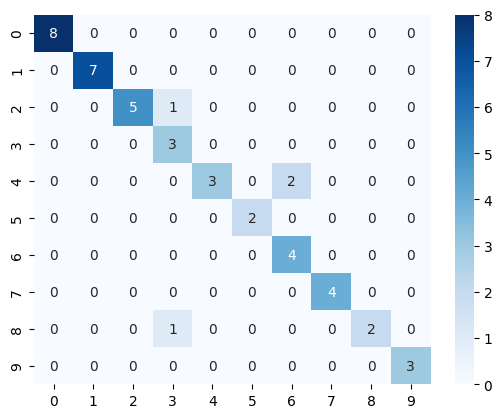

In [66]:
sns.heatmap(conf_matrix_val, annot=True, cmap='Blues')

<Axes: >

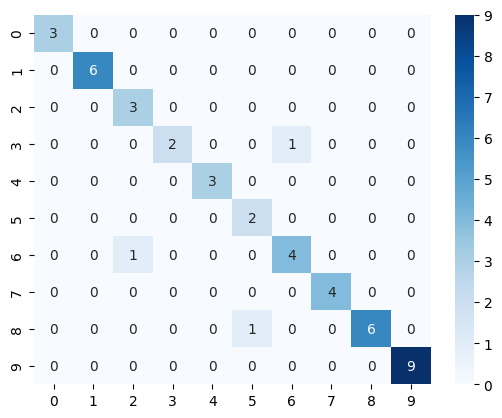

In [67]:
sns.heatmap(conf_matrix_test, annot=True, cmap='Blues')

In [58]:
# MODEL (10C_3)
metrics_df = pd.DataFrame(history.history)

In [64]:
metrics_df.head()

,loss,accuracy,val_loss,val_accuracy
0,2.405830,0.100000,2.450448,0.066667
1,2.341935,0.108333,2.313233,0.066667
2,2.274890,0.122222,2.260836,0.177778
3,2.222161,0.172222,2.239219,0.200000
4,2.206687,0.200000,2.285830,0.088889


<Axes: >

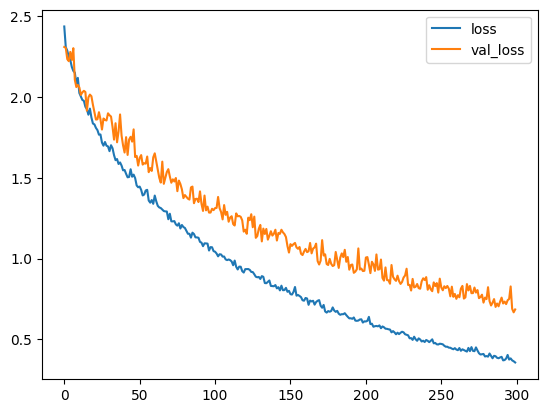

In [56]:
resultant_df[["loss","val_loss"]].plot()

<Axes: >

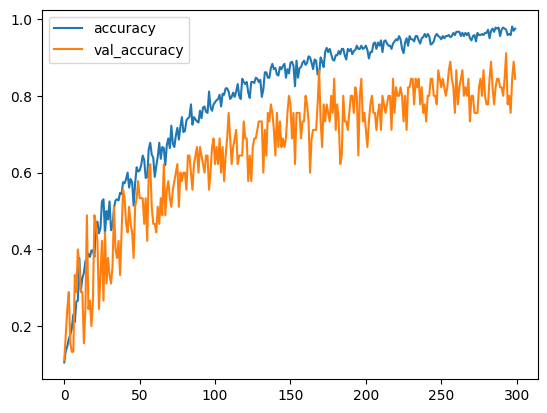

In [57]:
resultant_df[["accuracy","val_accuracy"]].plot()

In [63]:
y_pred_val = np.argmax(model.predict(X_val, batch_size=2), axis=-1)
y_val_t = np.argmax(y_val, axis=-1)
# For test set
y_pred_test = np.argmax(model.predict(X_test, batch_size=2), axis=-1)
y_test_t = np.argmax(y_test, axis=-1)

In [62]:
from tensorflow.keras.models import load_model
model = load_model(r'C:\Users\revan\Documents\FYP_HWU\Logs\ckpt.Res50_10C_4.keras')

In [64]:
evaluation_metrix (y_val_t, y_pred_val, y_test_t, y_pred_test)

Validation Accuracy: 0.9111111111111111
Test Accuracy: 0.9333333333333333
Validation Precision: 0.9437037037037037
Test Precision: 0.9462962962962962
Validation Recall: 0.9111111111111111
Test Recall: 0.9333333333333333
Validation F1-score: 0.9123232323232323
Test F1-score: 0.934065934065934


In [66]:
# train_dir = r'C:\Users\revan\Documents\FYP_HWU\extracted_features\training_val_Res50_10C_3.csv'
# # metrics_df.to_csv(log_dir)
# metrics_df.to_csv(train_dir, index=False)

### ResNet50 + BiLSTM

In [94]:
# For validation set
y_pred_val = np.argmax(hybrid_model2.predict(X_val1, batch_size = 2), axis=-1)
y_val_t = np.argmax(y_val1, axis=-1)
# For test set
y_pred_test = np.argmax(hybrid_model2.predict(X_test1, batch_size = 2), axis=-1)
y_test_t = np.argmax(y_test1, axis=-1)

In [97]:
evaluation_metrix (y_val_t, y_pred_val, y_test_t, y_pred_test)

Validation Accuracy: 0.8666666666666667
Test Accuracy: 0.9111111111111111
Validation Precision: 0.9022222222222223
Test Precision: 0.9435185185185184
Validation Recall: 0.8666666666666667
Test Recall: 0.9111111111111111
Validation F1-score: 0.872358505691839
Test F1-score: 0.9145441595441597


In [96]:
metrics_df1 = pd.DataFrame(history2_1.history)

<Axes: >

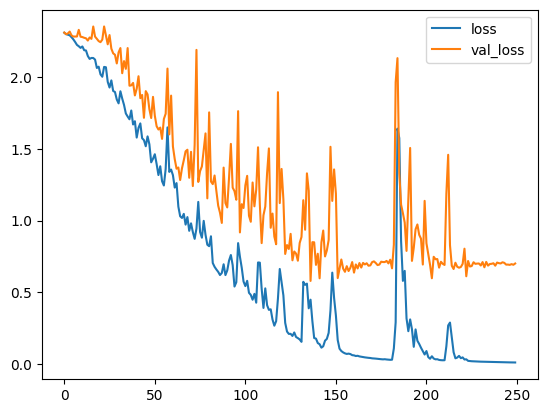

In [98]:
metrics_df1[["loss","val_loss"]].plot()

<Axes: >

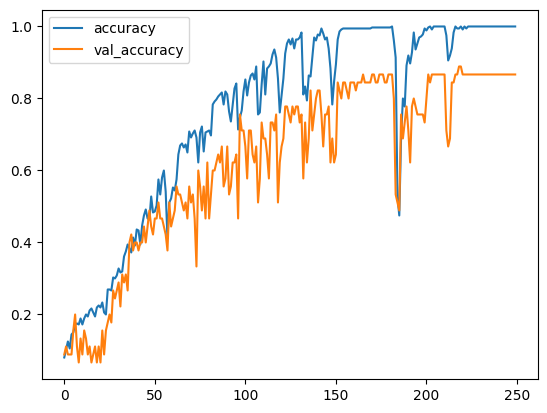

In [99]:
metrics_df1[["accuracy","val_accuracy"]].plot()

In [102]:
conf_matrix_val = confusion_matrix(y_val_t, y_pred_val)
conf_matrix_test = confusion_matrix(y_test_t, y_pred_test)

<Axes: >

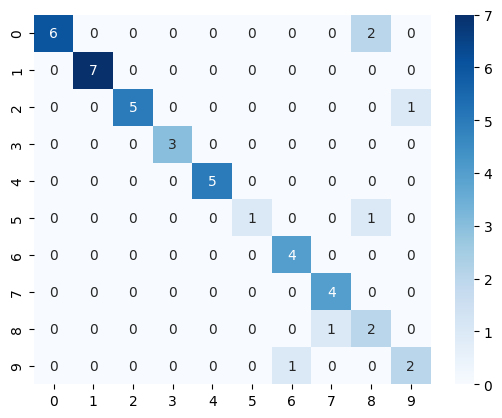

In [103]:
sns.heatmap(conf_matrix_val, annot=True, cmap='Blues')

<Axes: >

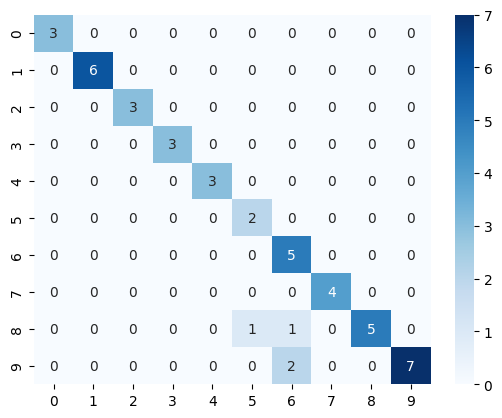

In [104]:
sns.heatmap(conf_matrix_test, annot=True, cmap='Blues')

### Xception + BiLSTM

In [77]:
# For validation set
y_pred_val = np.argmax(hybrid_model.predict(X_val, batch_size=2), axis=-1)
y_val_t = np.argmax(y_val, axis=-1)
# For test set
y_pred_test = np.argmax(hybrid_model.predict(X_test, batch_size=2), axis=-1)
y_test_t = np.argmax(y_test, axis=-1)

In [78]:
evaluation_metrix (y_val_t, y_pred_val, y_test_t, y_pred_test)

Validation Accuracy: 0.9333333333333333
Test Accuracy: 0.9111111111111111
Validation Precision: 0.9361111111111111
Test Precision: 0.912037037037037
Validation Recall: 0.9333333333333333
Test Recall: 0.9111111111111111
Validation F1-score: 0.9318518518518519
Test F1-score: 0.9038966697790226


In [71]:
metrics_df = pd.DataFrame(history.history)

<Axes: >

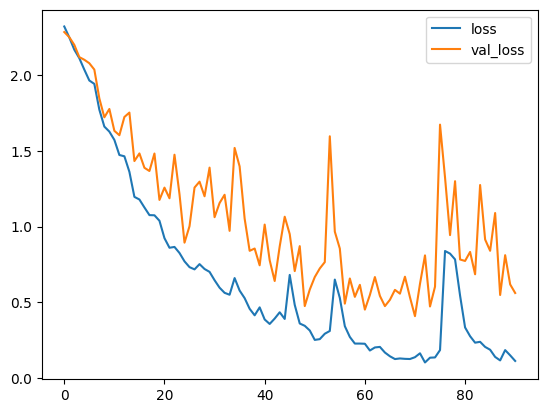

In [72]:
metrics_df[["loss","val_loss"]].plot()

<Axes: >

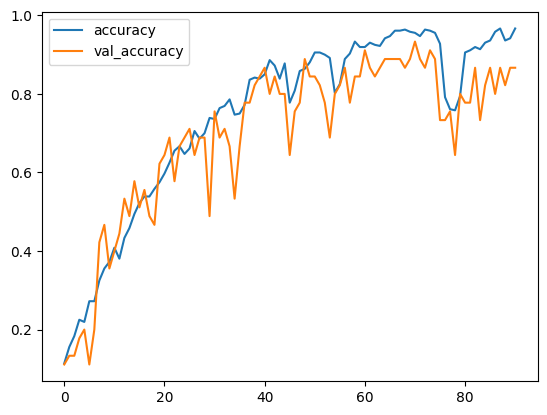

In [73]:
metrics_df[["accuracy","val_accuracy"]].plot()

In [79]:
conf_matrix_val = confusion_matrix(y_val_t, y_pred_val)
conf_matrix_test = confusion_matrix(y_test_t, y_pred_test)

<Axes: >

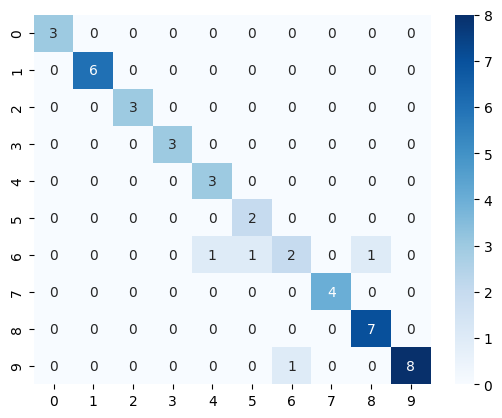

In [80]:
sns.heatmap(conf_matrix_test, annot=True, cmap='Blues')

<Axes: >

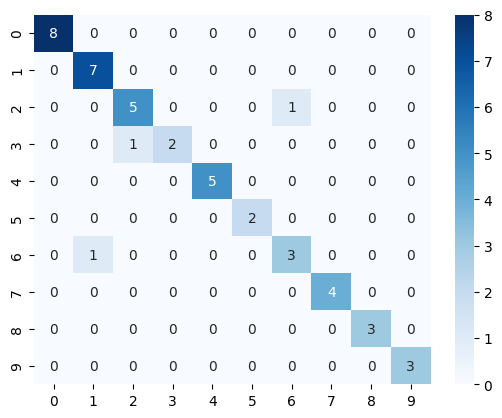

In [81]:
sns.heatmap(conf_matrix_val, annot=True, cmap='Blues')

### Xception (Alone)

In [41]:
# Epoch results
epoch_results = {
    "Epoch": list(range(1, 15)),  # Assuming you have 16 epochs
    "loss": [4.8294, 0.4135, 0.1524, 0.1016, 0.0243, 0.0151, 0.0060, 0.0020, 0.0016, 0.0014, 0.0011, 0.0013, 0.0011, 0.0012],
    "accuracy": [0.3222, 0.8639, 0.9556, 0.9639, 0.9944, 1.0000, 0.9972, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
    "val_loss": [2.1333, 0.6744, 0.8309, 0.2593, 0.2109, 0.1541, 0.1255, 0.1206, 0.1234, 0.1006, 0.1056, 0.1021, 0.1033, 0.1025],
    "val_accuracy": [0.6000, 0.8667, 0.7556, 0.8889, 0.9556, 0.9111, 0.9333, 0.9556, 0.9333, 0.9556, 0.9556, 0.9556, 0.9778, 0.9556]
}


# Convert to DataFrame
metrics_df = pd.DataFrame(epoch_results)

In [38]:
# For validation set
y_pred_val = np.argmax(hybrid_model1.predict(X_val, batch_size=2), axis=-1)
y_val_t = np.argmax(y_val, axis=-1)
# For test set
y_pred_test = np.argmax(hybrid_model1.predict(X_test, batch_size=2), axis=-1)
y_test_t = np.argmax(y_test, axis=-1)

In [39]:
evaluation_metrix (y_val_t, y_pred_val, y_test_t, y_pred_test)

Validation Accuracy: 0.9777777777777777
Test Accuracy: 0.9555555555555556
Validation Precision: 0.9814814814814816
Test Precision: 0.9620370370370371
Validation Recall: 0.9777777777777777
Test Recall: 0.9555555555555556
Validation F1-score: 0.9779331779331779
Test F1-score: 0.9545286195286196


In [43]:
metrics_df = pd.DataFrame(history.history)

<Axes: >

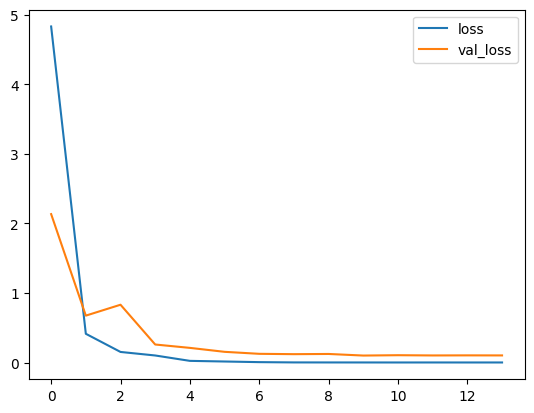

In [44]:
metrics_df[["loss","val_loss"]].plot()

<Axes: >

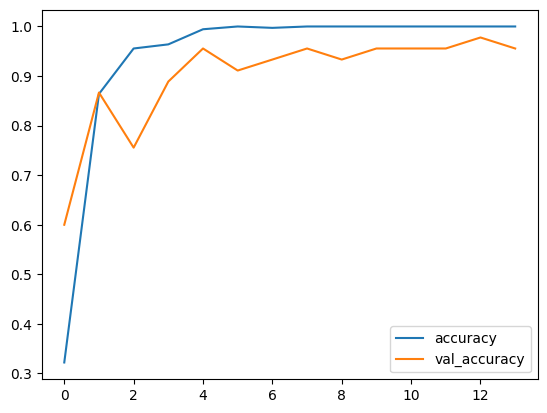

In [45]:
metrics_df[["accuracy","val_accuracy"]].plot()

In [46]:
conf_matrix_val = confusion_matrix(y_val_t, y_pred_val)
conf_matrix_test = confusion_matrix(y_test_t, y_pred_test)

<Axes: >

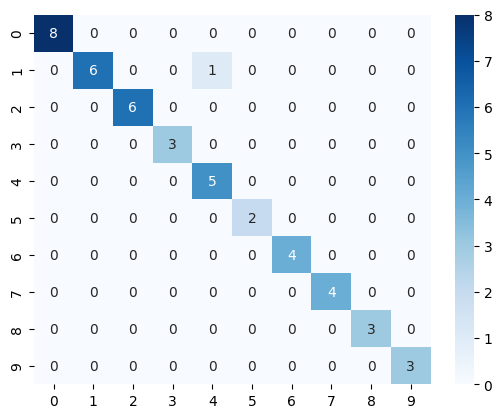

In [47]:
sns.heatmap(conf_matrix_val, annot=True, cmap='Blues')

<Axes: >

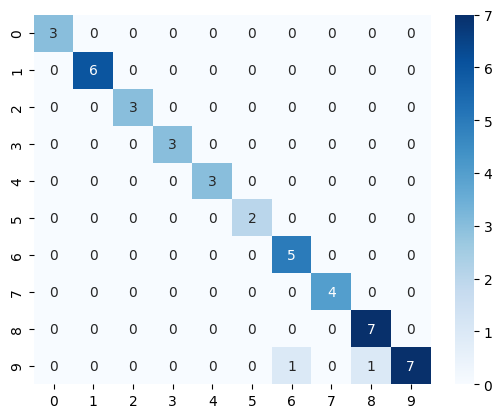

In [48]:
sns.heatmap(conf_matrix_test, annot=True, cmap='Blues')

# Top 100 videos (WLASL-100 dataset)

### Creating Subset (Top 100 classes)

In [1]:
top100words = ['book','drink','computer','before','chair','go','clothes','who','candy','cousin','deaf','fine','help',
'no','thin','walk','year','yes','all','black','cool','finish','hot','like','many','mother','now','orange','table',
'thanksgiving','what','woman','bed','blue','bowling','can','dog','family','fish','graduate','hat','hearing','kiss',
'language','later','man','shirt','study','tall','white','wrong','accident','apple','bird','change','color','corn',
'cow','dance','dark','doctor','eat','enjoy','forget','give','last','meet','pink','pizza','play','school','secretary',
'short','time','want','work','africa','basketball','birthday','brown','but','cheat','city','cook','decide','full',
'how','jacket','letter','medicine','need','paint','paper','pull','purple','right','same','son','tell','thursday'
]

In [40]:
# Initializing the path of the dataset
src_path = r'D:\WLASL Datasets\Kaggle_WLASL_withVideosInClassFolders\dataset\SL'
dest_path = r'C:\Users\revan\Documents\FYP_HWU\Videos_100'

In [7]:
import shutil
import os

In [8]:
# Making directories for 100 classes in dest path
# Creating one folder for each action
for action in top100words:
    try:
        os.makedirs(os.path.join(dest_path, action))
    except:
        pass

In [23]:
# Moving all videos from source dir to dest dir
# Creating a dictionary for all the actions/classes along with the count of videos for each action in the dataset
for root, dirs, files in os.walk(src_path):
    for i in dirs: #loop through each of the keywords or actions in the dataset
        if (i in top100words): #if the keyword is present in the shortlisted list of actions
                files = os.listdir(os.path.join(src_path, i)) #get files
                for file in files:
                    full_file_name = os.path.join(src_path, i, file) #add file name to the source path
                    shutil.copy(full_file_name, os.path.join(dest_path,i))   # copy file to dest path  
    break


In [25]:
# Counting videos in each class
# Initializing variables
video_count = {}

# Creating a dictionary for all the actions/classes along with the count of videos for each action in the dataset
for root, dirs, files in os.walk(dest_path):
    for i in dirs: #loop through each of the keywords or actions in the dataset
        for root, dirs, files in os.walk(os.path.join(dest_path, i)):
            video_count[i] = len(files) #get the number of videos per class and append to the dictionary
            break
    break

print(video_count)

{'accident': 13, 'africa': 9, 'all': 8, 'apple': 11, 'basketball': 12, 'bed': 13, 'before': 16, 'bird': 10, 'birthday': 6, 'black': 10, 'blue': 8, 'book': 6, 'bowling': 13, 'brown': 8, 'but': 7, 'can': 9, 'candy': 13, 'chair': 7, 'change': 12, 'cheat': 10, 'city': 9, 'clothes': 5, 'color': 8, 'computer': 14, 'cook': 8, 'cool': 16, 'corn': 12, 'cousin': 17, 'cow': 9, 'dance': 7, 'dark': 12, 'deaf': 11, 'decide': 9, 'doctor': 11, 'dog': 11, 'drink': 15, 'eat': 7, 'enjoy': 8, 'family': 11, 'fine': 9, 'finish': 9, 'fish': 10, 'forget': 7, 'full': 12, 'give': 13, 'go': 15, 'graduate': 10, 'hat': 9, 'hearing': 8, 'help': 14, 'hot': 10, 'how': 9, 'jacket': 7, 'kiss': 10, 'language': 10, 'last': 12, 'later': 12, 'letter': 11, 'like': 11, 'man': 12, 'many': 10, 'medicine': 8, 'meet': 9, 'mother': 11, 'need': 7, 'no': 11, 'now': 9, 'orange': 10, 'paint': 7, 'paper': 8, 'pink': 10, 'pizza': 12, 'play': 11, 'pull': 9, 'purple': 8, 'right': 9, 'same': 9, 'school': 9, 'secretary': 10, 'shirt': 12, '

In [64]:
# Creating folders to store frames

#Creating folder 'NEW_Frames' that will contain all the video frames
DATA_PATH = r'D:\FYP_HWU\WLASL100'
# os.makedirs(os.path.join(DATA_PATH,'WLASL100_Frames'))

#Creating one folder for each action
for action in video_paths.keys():
    # 1 folder for each video of the action
    for sequence in range(len(video_paths[action])):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

In [58]:
video_paths = {} #declaring an empty dictionary to store the file paths
# Creating a dictionary for all the actions/classes along with the count of videos for each action in the dataset
for root, dirs, files in os.walk(dest_path):
    for action in dirs:  # accessing files and folders under each class
        for root, dirs, files in os.walk(os.path.join(dest_path, action)):
            videos = []
            for i in range (len(files)):    # iterating through videos in the class folder
                videos.append(os.path.join(dest_path, action, files[i])) #storing video paths in the dictionary
            video_paths[action] = videos

    break

In [59]:
len(video_paths)

100

In [46]:
# storing the file paths (video paths) in a csv file
df = pd.DataFrame.from_dict(video_paths, orient='index')
df = df.transpose()
df.to_csv(r'C:\Users\revan\Documents\FYP_HWU\video_paths_100.csv', index=False)

### Frame Extraction

In [47]:
# Deciding how many frames to extract?
count = []
for action in video_paths.keys():
        #Looping through each video of the action
        for sequence in range(len(video_paths[action])):
            cap = cv2.VideoCapture(video_paths[action][sequence])
            total_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
            count.append(total_frames)
            cap.release()

In [56]:
cap = cv2.VideoCapture(r'C:/Users/revan/Documents/FYP_HWU/Videos_100/yes/69546.mp4')
total_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
cap.release()
print(total_frames)

72.0


In [48]:
max(count)

195.0

In [49]:
min(count)

19.0

In [55]:
video_paths[action][sequence]

'C:\\Users\\revan\\Documents\\FYP_HWU\\Videos_100\\yes\\69546.mp4'

In [66]:
DATA_PATH = r'D:\FYP_HWU\WLASL100'

In [67]:
# This function determines the frames to be skipped to extract frames from videos of variable lengths.
def frameSkipping(DATA_PATH,video_paths, n):
    for action in video_paths.keys():

        #Looping through each video of the action
        for sequence in range(len(video_paths[action])):
            cap = cv2.VideoCapture(video_paths[action][sequence])
            if cap.isOpened():
                total_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)  #getting the total frame count
                frames_step = total_frames//n    # getting the number of frames to skip

                for frame_num in range(n):
                    #position the pointer to the frame after skipping frames
                    cap.set(1,frame_num*frames_step)
                    success,image = cap.read()
                    #save the image
                    if success:
                        cv2.imwrite(os.path.join(DATA_PATH, action, str(sequence), 'frame'+ str(frame_num) + '.jpg'), image)
                    else:
                        print("Error in saving " + str(video_paths[action][sequence]))
            cap.release()

In [68]:
frameSkipping(DATA_PATH, video_paths, 19)

Error in saving C:\Users\revan\Documents\FYP_HWU\Videos_100\like\33273.mp4
Error in saving C:\Users\revan\Documents\FYP_HWU\Videos_100\same\49181.mp4


In [57]:
removeKeys = ['accident', 'africa', 'all', 'apple', 'basketball', 'bed', 'before', 'bird', 'birthday', 'black', 'blue']
for key in removeKeys:
    del video_paths[key]

### Frame Resizing

In [2]:
# Cropping the center of the image (cropping out the extra background margins of the video.)
def crop_center_square(frame): # takes image as a parameter
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y:start_y+min_dim,start_x:start_x+min_dim]

In [3]:
# Function to resize the frames
def resizeFrames(new_image, resize): # takes numpy array as parameter
    new_image = crop_center_square(new_image)
    new_image = cv2.resize(new_image, resize)
    return new_image # returns a numpy array

In [4]:
# Getting the final number of videos under each Action
def totalVideoCount(DATA_PATH):
    finalVideoCount = {}
    for root, dirs, files in os.walk(DATA_PATH):
        for action in dirs:
            for root, dirs, files in os.walk(os.path.join(DATA_PATH, action)):
                finalVideoCount[action] = len(dirs)
                break
    return finalVideoCount

In [6]:
max_fc = 19
resize = (224,224)
AUG_PATH = r'D:\FYP_HWU\WLASL100\AUG_FRAMES'
DATA_PATH = r'D:\FYP_HWU\WLASL100\NEW_FRAMES'

videoCount = totalVideoCount(DATA_PATH) #getting a video count from original frame dataset

#looping through each action
for action in videoCount.keys():

    #Looping through the count for videos for that action
    for sequence in range(videoCount[action]):

        #creating a folder in AUG frames folder
        try:
            os.makedirs(os.path.join(AUG_PATH, action, str(sequence)))
        except:
            pass

        # iterating through each frame in the original frame dataset
        for frame_num in range (max_fc):
            IMAGE_PATH = os.path.join(DATA_PATH, str(action), str(sequence) , 'frame' + str(frame_num) + '.jpg')

            # Reading the image
            image = cv2.imread(IMAGE_PATH)

            new_image = resizeFrames(image, resize)

            #Saving the image in the folder created
            cv2.imwrite(os.path.join(AUG_PATH, str(action), str(sequence), 'frame' + str(frame_num) + '.jpg'), new_image)

            # Displaying Image
            cv2.destroyAllWindows()


In [7]:
video_count1 = sorted(videoCount.items(), key=lambda x:x[1], reverse = True)  #sorting the dictionary based on the number of videos and reversing it to arrange in s=descending order

In [12]:
video_count1[-1]

('clothes', 5)

### Data Augmentation

In [14]:
def blackAndWhite(image): # takes image as a parameter
    # Image color
    enhancer = ImageEnhance.Color(image)
    new_image = enhancer.enhance(0)

    # return np.array(new_image)
    return new_image

In [15]:
def saturation(image): # takes image as a parameter
    # Horizontally flipping the image
    image = flipImage(image)
    # Image color
    enhancer = ImageEnhance.Color(image)
    new_image = enhancer.enhance(1.5)

    # return np.array(new_image)
    return new_image

In [17]:
def flipImage(image): # takes image as a parameter
    # Converting Image to numpy array
    new_image = np.array(image)

    # Horizontally flipping the image
    image = cv2.flip(new_image, 1)

    # Converting numpy aray to image format
    image = Image.fromarray(image.astype('uint8'))

    # Returning the image in image format
    return image

In [18]:
def rotateImage(image):
    image  = image.rotate(-8)  #- or + -> left or right
    return image

In [22]:
max_fc = 19  #maximum number of frames extracted per video
resize = (224,224) #dimensions to resize the image to
AUG_PATH = r'D:\FYP_HWU\WLASL100\AUG_FRAMES' # defining file path to store the video frames after data augmentation
DATA_PATH = r'D:\FYP_HWU\WLASL100\NEW_FRAMES'

finalVideoCount = totalVideoCount(AUG_PATH)
video_count = totalVideoCount(DATA_PATH)

#looping through each action
for action in video_count.keys():
    actionCount = finalVideoCount[action]

    #Looping through the count for videos for that action
    for sequence in range(video_count[action]):

        #creating a folder to store the augmented images
        folder_number = actionCount + sequence
        if(folder_number < 25):  # limiting number of videos under each class to be 25
            try:
                os.makedirs(os.path.join(AUG_PATH, action, str(folder_number)))
            except:
                pass #pass if the folder has already been created

            for frame_num in range (max_fc):
                IMAGE_PATH = os.path.join(AUG_PATH, str(action), str(sequence) , 'frame' + str(frame_num) + '.jpg')

                # Reading the image
                image = cv2.imread(IMAGE_PATH)

                #Converting numpy array to Image
                image = Image.fromarray(image.astype('uint8'))

                # Applying the filters
                # new_image = blackAndWhite(image)
                # new_image = flipImage(image)
                new_image = saturation(image)
                # new_image = rotateImage(image)

                # Converting Image to numpy array
                new_image = np.array(new_image)

                #Saving the image in the folder created
                cv2.imwrite(os.path.join(AUG_PATH , str(action), str(folder_number), 'frame'+ str(frame_num) + '.jpg'), new_image)

                # Displaying Image
                cv2.destroyAllWindows()

        else:
            break


In [33]:
max_fc = 19  #maximum number of frames extracted per video
resize = (224,224) #dimensions to resize the image to
for frame_num in range (max_fc):
    IMAGE_PATH = os.path.join(r'D:\FYP_HWU\WLASL100\AUG_FRAMES\accident\11', 'frame' + str(frame_num) + '.jpg')

    # Reading the image
    image = cv2.imread(IMAGE_PATH)

    #Converting numpy array to Image
    image = Image.fromarray(image.astype('uint8'))

    # Applying the filters
    # new_image = blackAndWhite(image)
    # new_image = flipImage(image)
    # new_image = saturation(image)
    new_image = rotateImage(image)

    # Converting Image to numpy array
    new_image = np.array(new_image)

    #Saving the image in the folder created
    cv2.imwrite(os.path.join(r'D:\FYP_HWU\WLASL100\AUG_FRAMES\accident\13', 'frame'+ str(frame_num) + '.jpg'), new_image)

    cv2.destroyAllWindows()

### MediaPipe Keypoints

In [27]:
import mediapipe as mp
# !pip3 install mediapipe --user

In [28]:
mp_holistic = mp.solutions.holistic #Holistic model (use for detections)
mp_drawing = mp.solutions.drawing_utils #Drawing Utilities
drawing_spec = mp_drawing.DrawingSpec(thickness = 1, circle_radius=1)

In [29]:
#Capturing landmarks
def mediapipeHolistics(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #color conversion -> BGR to RGB
    image.flags.writeable = False
    results = model.process(image) # Making Prediction
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) #color conversion -> RGB to BGR
    return image, results

In [30]:
#Visualize landmarks, connecting the landmarks on the image (drawing only pose and had landmarks)
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image = image,
                              landmark_list = results.pose_landmarks,
                              connections = mp_holistic.POSE_CONNECTIONS,
                              landmark_drawing_spec = drawing_spec,
                              connection_drawing_spec = drawing_spec)
    mp_drawing.draw_landmarks(image = image,
                              landmark_list = results.left_hand_landmarks,
                              connections = mp_holistic.HAND_CONNECTIONS,
                              landmark_drawing_spec = drawing_spec,
                              connection_drawing_spec = drawing_spec)
    mp_drawing.draw_landmarks(image = image,
                              landmark_list = results.right_hand_landmarks,
                              connections = mp_holistic.HAND_CONNECTIONS,
                              landmark_drawing_spec = drawing_spec,
                              connection_drawing_spec = drawing_spec)

In [34]:
max_fc = 19
AUG_PATH = r'D:\FYP_HWU\WLASL100\AUG_FRAMES'
MP_FRAMES_PATH = r'D:\FYP_HWU\WLASL100\MP_FRAMES'

finalVideoCount = totalVideoCount(AUG_PATH)

#looping through each action
for action in finalVideoCount.keys():

    #Looping through the count for videos for that action
    for sequence in range(finalVideoCount[action]):

        # Creating folders to store frames and extracted landmarks
        try:
            os.makedirs(os.path.join(MP_FRAMES_PATH, action, str(sequence)))
        except:
            pass

        with mp_holistic.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:
            for frame_num in range (max_fc):

                # Getting the extracted frame from the folder
                IMAGE_PATH = os.path.join(AUG_PATH, str(action), str(sequence) , 'frame' + str(frame_num) + '.jpg')

                # Reading the image
                image = cv2.imread(IMAGE_PATH)

                # Making detection
                image, result = mediapipeHolistics(image, holistic)

                #Darwing landmarks on frames
                draw_landmarks(image,result)

                #Saving the image in the folder created
                cv2.imwrite(os.path.join(MP_FRAMES_PATH , str(action), str(sequence), 'frame'+ str(frame_num) + '.jpg'), image)

                # Displaying Image
                cv2.destroyAllWindows()
